# The Package Detectives: Cracking the Case with Data  

### Description:  
Hey there, data scientist! Have you ever wondered what happens when packages go missing in transit? A logistics company is facing this exact issue, with a significant number of packages vanishing without a trace. The company has collected data on its shipments, but needs your expertise to unravel the mystery. Can you use your Pandas skills to help the company identify the root cause of the problem and recover the missing packages?  

### Tasks:  
- **Package Profiling:** Create a summary of package shipments by region, including the number of packages sent, received, and missing.  
- **Route Analysis:** Identify the most common routes where packages go missing, and calculate the average distance for these routes.  
- **Carrier Comparison:** Compare the performance of different carriers, including their package loss rates and average delivery times.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The dataset contains information about packages shipped by a logistics company, including the package ID, region, carrier, shipment and delivery dates, route ID, and a "missing" column indicating the packages missing in each destination city. The dataset also includes a separate table with route information, including origin and destination cities, and distance.

### Columns:  
**packages:**  
- **package_id (int):** Unique package identifier
- **route_id (int):** Foreign key from the routes dataset  
- **region (str):** Region where package was shipped from  
- **carrier (str):** Carrier responsible for shipment  
- **shipment_date (datetime):** Date package was shipped  
- **delivery_date (datetime):** Date package was delivered (if not missing)  
- **missing (bool):** Indicator of whether package is missing  

**routes:**  
- **route_id (int):** Unique route identifier  
- **origin (str):** City where route originates  
- **destination (str):** City where route terminates  
- **distance (float):** Distance of route in miles  

In [2]:
# set the seed
np.random.seed(0)

packages = pd.DataFrame({
    'package_id': range(1000),
    'region': np.random.choice(['North', 'South', 'East', 'West'], size=1000),
    'carrier': np.random.choice(['CarrierA', 'CarrierB', 'CarrierC'], size=1000),
    'shipment_date': pd.date_range('2022-01-01', periods=1000),
    'route_id': np.random.choice(range(100), size=1000)
})

# generate delivery dates
packages['delivery_date'] = packages.apply(lambda x: x['shipment_date'] + pd.Timedelta(days=np.random.randint(1, 60)), axis=1)

routes = pd.DataFrame({
    'route_id': range(100),
    'origin': np.random.choice(['CityA', 'CityB', 'CityC'], size=100),
    'destination': np.random.choice(['CityD', 'CityE', 'CityF'], size=100),
    'distance': np.random.uniform(100, 1000, size=100)
})

# merge the dataframes
df = packages.merge(routes, on='route_id')

# force a pattern to the missing packages
df['missing'] = np.where(
    df['destination'] == 'CityF', 
    np.random.choice([True, False], size=1000, p=[0.15, 0.85]),
    np.where(
        df['destination'] == 'CityD', 
        np.random.choice([True, False], size=1000, p=[0.2, 0.8]),
        np.where(
            df['destination'] == 'CityE', 
            np.random.choice([True, False], size=1000, p=[0.8, 0.2]),
            np.random.choice([True, False], size=1000, p=[0.1, 0.9]) # other
        )
    )
)

# make sure delivery date is null if the package is missing
missing = df['missing'] == True
df.loc[missing, 'delivery_date'] = np.nan

df.head()

,package_id,region,carrier,shipment_date,route_id,delivery_date,origin,destination,distance,missing
0,0,North,CarrierC,2022-01-01,75,2022-01-19,CityA,CityF,508.947668,False
1,1,West,CarrierA,2022-01-02,56,2022-01-22,CityA,CityF,984.760182,False
2,2,South,CarrierA,2022-01-03,43,2022-01-23,CityC,CityF,850.541203,False
3,3,North,CarrierC,2022-01-04,24,2022-01-06,CityC,CityE,357.532844,False
4,4,West,CarrierA,2022-01-05,81,2022-02-02,CityB,CityF,556.871923,False


Let's look at the data types to ensure all of the column are of the correct type.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   package_id     1000 non-null   int64         
 1   region         1000 non-null   object        
 2   carrier        1000 non-null   object        
 3   shipment_date  1000 non-null   datetime64[ns]
 4   route_id       1000 non-null   int32         
 5   delivery_date  605 non-null    datetime64[ns]
 6   origin         1000 non-null   object        
 7   destination    1000 non-null   object        
 8   distance       1000 non-null   float64       
 9   missing        1000 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int32(1), int64(1), object(4)
memory usage: 67.5+ KB


# Package Profiling:  

Create a summary of package shipments by region, including the number of packages sent, received, and missing.  

Take note that we are able to filter the rows of a column before applying the aggregate function.  

`lambda x: x[x==True]`  
- We find all of the rows where the `missing` column is equal to True
- After we have filtered the data, we count the remaining items

This functionality allows us to determine how many packages are missing per region.

In [4]:
# create group object
group = df.groupby('region')

# get summary stats
result = group.agg(
     sent=pd.NamedAgg(column="shipment_date", aggfunc="count"),
     received=pd.NamedAgg(column="delivery_date", aggfunc="count"),
     missing=pd.NamedAgg(column="missing", aggfunc=lambda x: x[x==True].count())
)

# add percentage missing for clarity
result['pct_missing'] = result['missing'] / result['sent']
result

,sent,received,missing,pct_missing
region,,,,
East,241,156,85,0.352697
North,255,159,96,0.376471
South,253,141,112,0.442688
West,251,149,102,0.406375


Based on the results above, we can see that the southern region has the most missing packages, but we should continue analyzing the data before we determine the southern region is the root cause of the missing packages.

# Route Analysis:  

Identify the most common routes where packages go missing, and calculate the average distance for these routes.

In [5]:
# calculate the days in transit
df['time_in_transit'] = (df['delivery_date'] - df['shipment_date']).dt.days

# missing packages
missing = df['missing'] == True
df_missing = df[missing]

df_missing.head()

,package_id,region,carrier,shipment_date,route_id,delivery_date,origin,destination,distance,missing,time_in_transit
7,7,West,CarrierA,2022-01-08,18,NaT,CityB,CityE,875.626127,True,NaN
9,9,West,CarrierC,2022-01-10,89,NaT,CityA,CityF,580.740419,True,NaN
10,10,South,CarrierB,2022-01-11,29,NaT,CityA,CityE,515.475425,True,NaN
13,13,West,CarrierC,2022-01-14,40,NaT,CityC,CityE,994.064699,True,NaN
15,15,North,CarrierC,2022-01-16,11,NaT,CityC,CityE,238.850000,True,NaN


Now that we have all of the routes that are missing, let us calculate the average distance for these routes.

In [6]:
# create group object
group = df_missing.groupby('route_id')

# average distance for these routes
group.mean(numeric_only=True)['distance']

route_id
0     524.497660
1     732.105228
3     272.413912
4     695.956811
5     866.191094
         ...    
93    460.459417
94    469.824161
97    187.122897
98    900.785922
99    155.660305
Name: distance, Length: 85, dtype: float64

Another perspective we can use to tackle this task:  
- Compare the average distance for the routes that went missing and the routes that made it to their final destination.  

> Can you find a correlation?

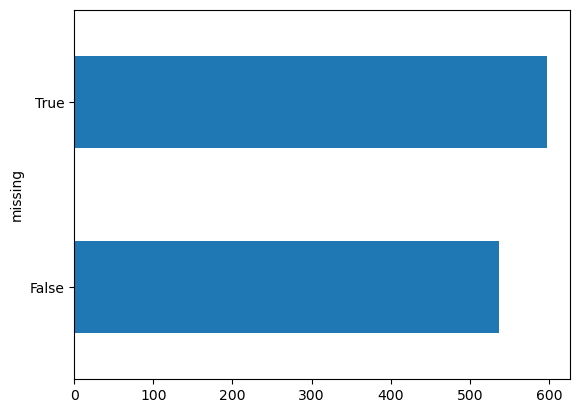

In [7]:
# create group object
group = df.groupby('missing')

# average distance for these routes
group.mean(numeric_only=True)['distance'].plot.barh();

The routes that went missing do seem to be the longest routes. Does this mean distance is a factor in why the packages are going missing? Maybe, but let us continue exploring.

# Carrier Comparison:  

Compare the performance of different carriers, including their package loss rates and average delivery times.

In [8]:
# create group object
group = df.groupby('carrier')

# average distance for these routes
group.agg(
     loss_rate=pd.NamedAgg(column="missing", aggfunc=lambda x: x[x==True].count() / x.count()),
     avg_delivery_times=pd.NamedAgg(column="time_in_transit", aggfunc="mean")
)

,loss_rate,avg_delivery_times
carrier,,
CarrierA,0.385757,29.101449
CarrierB,0.425656,30.578680
CarrierC,0.371875,29.343284


The chart above should tell us if any of the carriers is mainly responsible for he missing packages. Unfortunately, from the data, it does not seem like the carrier has much to do with the missing packages.

Let us see if the destination city has anything to do with these packages that are vanishing mysteriously. 

In [9]:
# create group object
group = df.groupby('destination')

# average distance for these routes
group.agg(
     loss_rate=pd.NamedAgg(column="missing", aggfunc=lambda x: x[x==True].count() / x.count())
)

,loss_rate
destination,
CityD,0.201439
CityE,0.832370
CityF,0.135638


Aha! Do you see what I see?  

80% of the packages that had a destination to CityE went missing...  

This is a significant data point that may help us solve the mistery. Something seems to be happening to packages that are in route to CityE. What could the issue be?

I want to make sure there are no other variables that we need to consider.  

If we compare the destination city against the following columns, do we still see the missing packages pattern?  
- region
- carrier
- origin

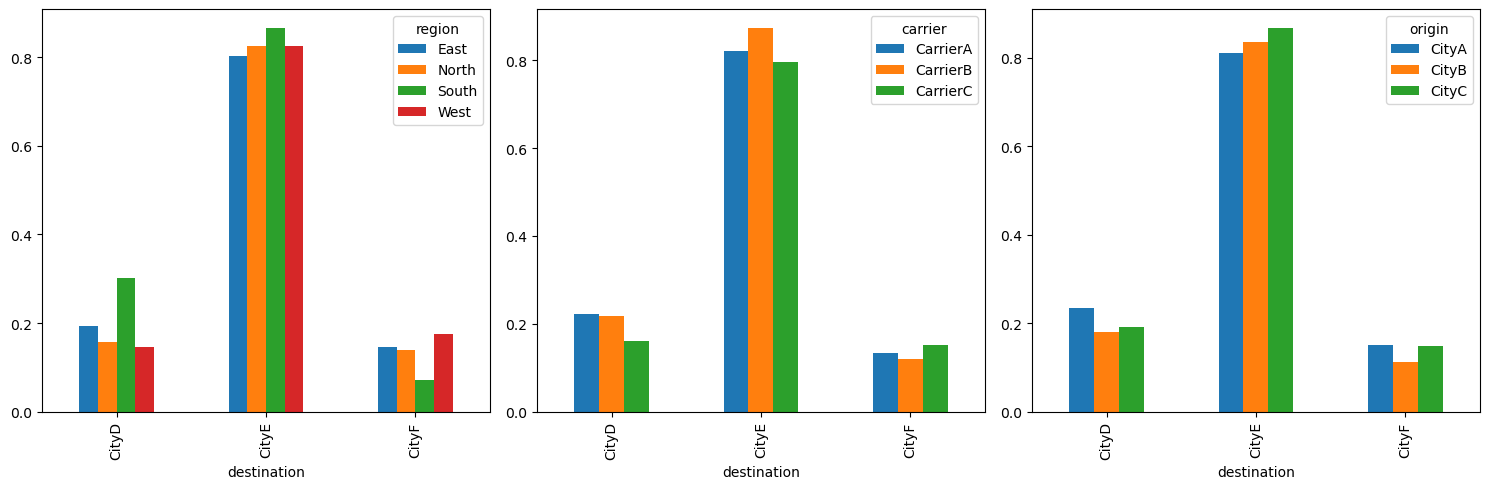

In [10]:
import matplotlib.pyplot as plt

# create a grid of charts
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# plot each column in the pivot table in a separate chart
for ax, col in zip(axs.flatten(), ['region','carrier','origin']):
    df.pivot_table(index='destination', columns=col, values='missing', aggfunc=lambda x: x[x==True].count() / x.count()).plot.bar(ax=ax)

# customize the layout
plt.tight_layout()
plt.show()

We can clearly see that regardless of the origin city, the region, or the carrier. Packages in route to CityE have a very high chance of going missing. I would recommend the logistics company immediately stop sending packages to this city and do a thorough investigation to determine the root cause.

# Summary  

**Based on the analysis, it was determined that:**  
- Packages that went missing had longer routes on average, suggesting distance might be a factor.  
- Carrier performance did not seem to be a significant factor in missing packages.  
- However, a significant finding was that 80% of packages destined for CityE went missing, suggesting a specific issue with deliveries to that city.     

In summary, further analysis showed that this pattern persisted regardless of origin city, region, or carrier, leading to the recommendation for the logistics company to stop sending packages to CityE and investigate the root cause.

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>